In [1]:
from pandas import DataFrame, read_csv, read_excel
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patches as patches
import seaborn as sns
import statsmodels.api as sm
from matplotlib.lines import Line2D
import itertools
from pygam import GAM, s, te, l
np.int = int #workaround for deprecated pygam
import matplotlib.patches as mpatches
import glob

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [2]:
sample_collection_file = 'sample_collection_numbers.xlsx'
sample_collection_df = read_excel(sample_collection_file)

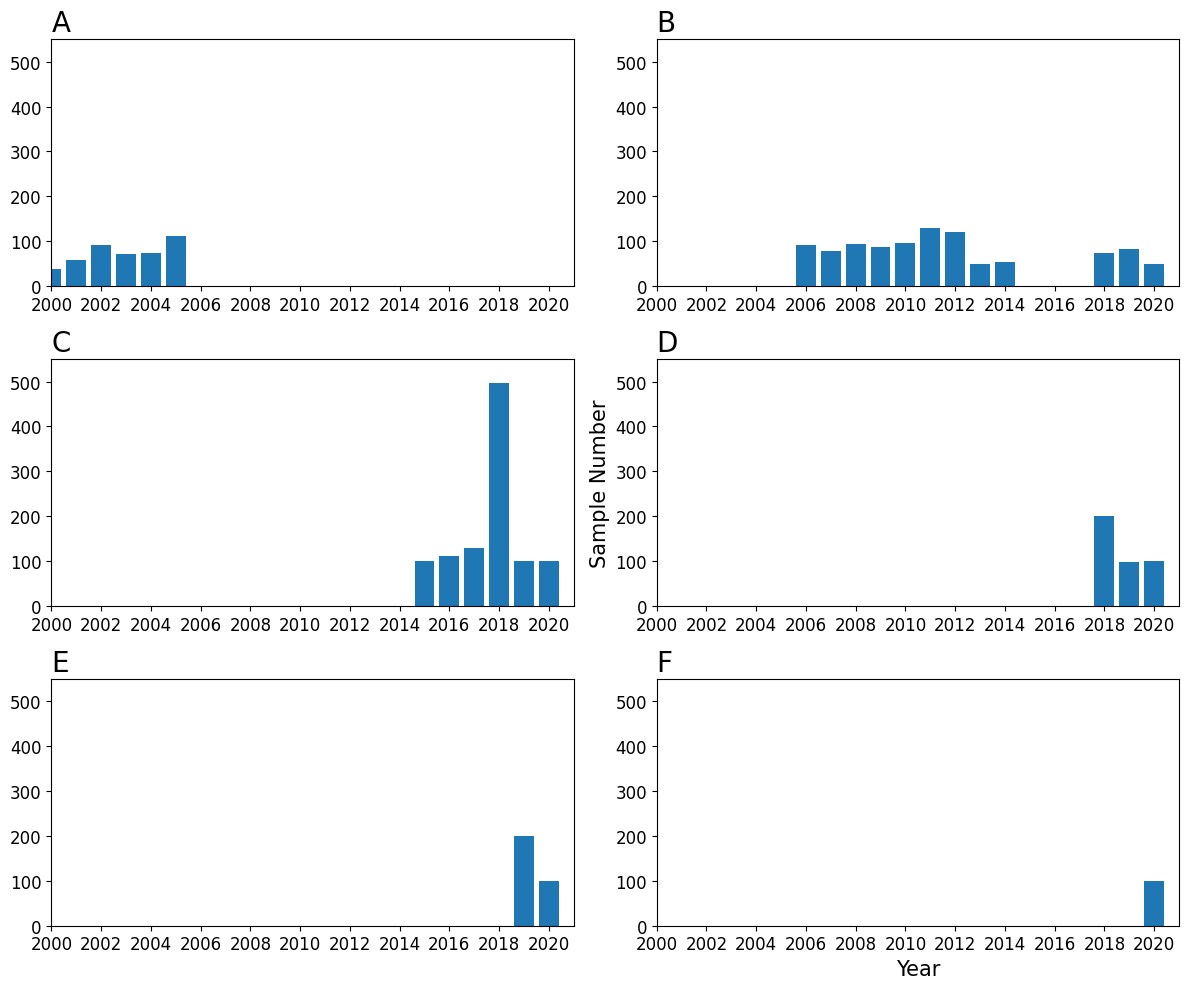

In [3]:
fig = plt.figure(figsize=(12,10))
axes =  [plt.subplot(3,2,i+1) for i in range(6)]
fig.figsize=(12,12)
colors = ['green', 'green', 'red', '#C7F620', 'orange', '#C7F620']
for i,column in enumerate(['Pikine','Thies', 'Kedougou', 'Diourbel', 'Kolda', 'Kaolack']):
    axes[i].bar(sample_collection_df['Year'], sample_collection_df[column])
    axes[i].set_ylim(0,550)
    axes[i].tick_params(labelsize = 12)
    axes[i].set_title('ABCDEFGHIJKL'[i], fontsize = 20, loc = 'left')
    axes[i].set_xlim(2000,2021)
    axes[i].set_xticks(range(2000,2021,2))
    axes[i].set_xticklabels(range(2000,2021,2))
    
axes[-1].set_xlabel('Year', fontsize = 15)
axes[3].set_ylabel('Sample Number', fontsize = 15)
fig.tight_layout()
fig.savefig('/Users/weswong/Wirth Lab Dropbox/wes wong/DrugR/Figures/sampling.svg', dpi = 300)

In [4]:
def convert_string(str_input):
    return string_converter[str_input]
string_converter = {'-': None, '/': None, 
                    'MIX':'MIX','436A/437A': 'MIX','BOTH': 'MIX','MUT+WT': 'MIX','WT+NEW': 'MIX','WT/MUT':'MIX',
                    '7G8': 'MUT','MUT': 'MUT','MUT ': 'MUT','MUT 436': 'MUT','MUT 7G8': 'MUT',
                    'MUT TM90': 'MUT','MUT1': 'MUT','MUT2':'MUT','MUT436': 'MUT',
                    'N': None,'NAN': None,'NEG': None,'NEG ': None,'NEGATIVE': None,
                    'NEW?': None, 'NVMUT':None, 'UNKNOWN': None,
                    'T/C': 'MUT',
                    'TM9':'MUT',
                    'WT': 'WT',
                   }

master_df = DataFrame(read_excel('longitudinal_drugR.xlsx'))
locations = Counter(master_df['Location'])
geographic_counts = defaultdict(lambda: {})
drug_mutations = {'PFCRT': ['PFCRTK76T'],
                 'MDR1':['MDR1N86Y', 'MDR1Y184F', 'MDR11042D', 'MDR1D1246Y'],
                 'DHFR': ['DHFRN51C','DHFRC59R', 'DHFRS108N', 'DHFRI164L'],
                 'DHPS': ['DHPSA437G','DHPSK540E','DHPSA581G', 'DHPS613T/S'],
                 'K13': ['K13C580Y', 'K13A578S']}

possible_strings = []
converted_df = DataFrame()
for column in master_df.columns[0:6]:
    converted_df[column] = list(master_df[column])
for column in master_df.columns[6:]:
    converted_df[column] = [convert_string(str_input) for str_input in [str(x).upper() for x in list(master_df[column])]]
converted_df.to_excel('longitudinal_drugR_name_converted.xlsx')

geographic_dfs = defaultdict(lambda: {})
for location, geo_df in converted_df.groupby('Location'):
    for year, df in geo_df.groupby('Year'):
        geographic_dfs[location][year] = df
location_cpalette = {}
examined_locations = ['Pikine', 'Thies', 'Kedougou', 'Diourbel', 'Kolda', 'Kaolack', 'DiourbelTES']
for location, color in zip(examined_locations, 
                           sns.color_palette('Set2', len(examined_locations)).as_hex()):
    location_cpalette[location] = color

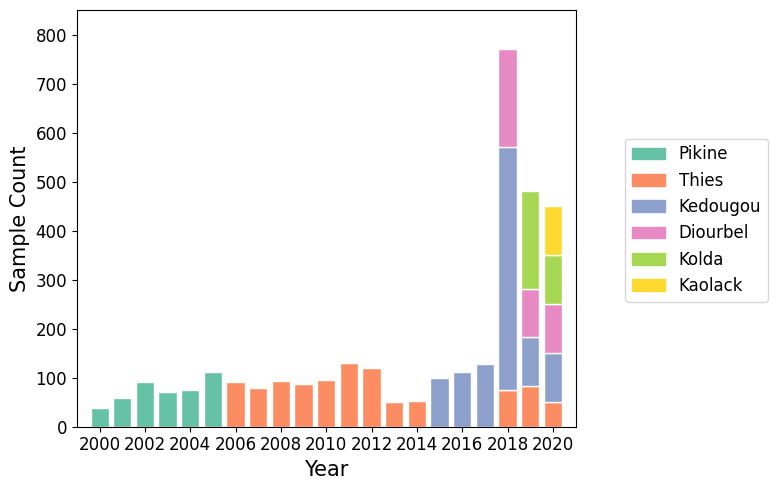

In [5]:
fig = plt.figure(figsize=(8,5))
axes =  [plt.subplot(1,1,1) for i in range(1)]
fig.figsize=(12,12)
colors = ['green', 'green', 'red', '#C7F620', 'orange', '#C7F620']
bottom = [0. for _ in sample_collection_df['Year']]
for i,column in enumerate(['Pikine','Thies', 'Kedougou', 'Diourbel', 'Kolda', 'Kaolack']):
    axes[0].bar(sample_collection_df['Year'], sample_collection_df[column], 
                bottom=bottom, color = location_cpalette[column], edgecolor = 'white')
    
    axes[0].set_ylim(0,550)
    axes[0].tick_params(labelsize = 12)
    axes[0].set_xlim(1999,2021)
    axes[0].set_xticks(range(2000,2021,2))
    axes[0].set_xticklabels(range(2000,2021,2))
    axes[0].set_ylim(0,850)
    axes[0].set_xlabel('Year', fontsize = 15)
    axes[0].set_ylabel('Sample Count', fontsize = 15)
    bottom += np.asarray([x if not np.isnan(x) else 0 for x in sample_collection_df[column]])
    
legend_patches =[mpatches.Patch(color=location_cpalette[key], label=key) for key in location_cpalette if key != 'DiourbelTES']
axes[0].legend(handles=legend_patches, fontsize = 12, loc = (1.1,0.3))

fig.tight_layout()

In [6]:
longitudinal_drugR= defaultdict(lambda: defaultdict(list))
conversion_dict = {'MUT':1, 'WT':0, None:'X', 'MIX': 'X'}

for location in geographic_dfs:
    for year in geographic_dfs[location]:
        for drugR in master_df.columns[6:]:
            counts = Counter(geographic_dfs[location][year][drugR])
            total = np.sum(list(counts.values())) - counts[None] - counts['MIX']
            print(location, year,drugR, total,counts)
            p_mut = (counts['MUT'] ) / total 
            stdev = np.sqrt((p_mut * (1- p_mut) )/total)
            longitudinal_drugR[location][drugR].append((p_mut, stdev, total))
        
        #MDR1 haplotypes
        df = geographic_dfs[location][year]
        mdr1_haplotypes = defaultdict(list)
        for sample in df[['MDR1N86Y','MDR1Y184F', 'MDR1D1246Y']].to_numpy():
            mdr1_haplotypes[year].append(('').join([str(conversion_dict[allele]) for allele in sample]))
        counts = Counter(mdr1_haplotypes[year])
        incomplete_haps = 0
        for c in counts:
            if 'X' not in c:
                continue
            else:
                incomplete_haps += counts[c]
        total = np.sum(list(counts.values())) - incomplete_haps
        print('mdr1', counts, total, incomplete_haps)
        for haplotype in ["".join(seq) for seq in itertools.product("01", repeat=3)]:
            if counts[haplotype]:
                print(haplotype)
                p_mut = (counts[haplotype] ) / total 
                stdev = np.sqrt((p_mut * (1- p_mut) )/total)
                longitudinal_drugR[location]['MDR1_hap' + haplotype].append((p_mut, stdev, total))
            else:
                longitudinal_drugR[location]['MDR1_hap'+ haplotype].append((np.nan,np.nan,total))
        
        #dhfr haplotypes
        dhfr_haplotypes = defaultdict(list)
        for sample in df[['DHFRN51C','DHFRC59R', 'DHFRS108N', ]].to_numpy():
            dhfr_haplotypes[year].append(('').join([str(conversion_dict[allele]) for allele in sample]))
        counts = Counter(dhfr_haplotypes[year])
        incomplete_haps = 0
        for c in counts:
            if 'X' not in c:
                continue
            else:
                incomplete_haps += counts[c]
        total = np.sum(list(counts.values())) - incomplete_haps
        print('dhfr', counts, total, incomplete_haps)
        print(counts, total)
        for haplotype in ["".join(seq) for seq in itertools.product("01", repeat=3)]:
            if counts[haplotype]:
                p_mut = (counts[haplotype] ) / total 
                stdev = np.sqrt((p_mut * (1- p_mut) )/total)
                longitudinal_drugR[location]['DHFR_hap' + haplotype].append((p_mut, stdev, total))
            else:
                longitudinal_drugR[location]['DHFR_hap'+ haplotype].append((np.nan,np.nan,total))
        
        #dhfr_dhps_haplotypes
        dhfr_dhps_haplotypes= defaultdict(list)
        for sample in df[['DHFRN51C','DHFRC59R', 'DHFRS108N', 'DHPSA437G']].to_numpy():
            dhfr_dhps_haplotypes[year].append(('').join([str(conversion_dict[allele]) for allele in sample]))
        counts = Counter(dhfr_dhps_haplotypes[year])
        incomplete_haps = 0
        for c in counts:
            if 'X' not in c:
                continue
            else:
                incomplete_haps += counts[c]
        total = np.sum(list(counts.values())) - incomplete_haps
        print(counts, total, incomplete_haps)
        for haplotype in ["".join(seq) for seq in itertools.product("01", repeat=4)]:
            if counts[haplotype]:
                p_mut = (counts[haplotype] ) / total 
                stdev = np.sqrt((p_mut * (1- p_mut) )/total)
                longitudinal_drugR[location]['DHFR_DHPS_hap' + haplotype].append((p_mut, stdev, total))
            else:
                longitudinal_drugR[location]['DHFR_DHPS_hap'+ haplotype].append((np.nan,np.nan,total))
                
mdr1_haps = [key for key in longitudinal_drugR['Kedougou'].keys() if 'MDR1_hap' in key]
dhfr1_haps = [key for key in longitudinal_drugR['Kedougou'].keys() if 'DHFR_hap' in key]
dhfr_dhps_haps = [key for key in longitudinal_drugR['Kedougou'].keys() if 'DHFR_DHPS_hap' in key]

Diourbel 2018 PFCRTK76T 181 Counter({'WT': 95, 'MUT': 86, None: 17, 'MIX': 2})
Diourbel 2018 MDR1N86Y 171 Counter({'WT': 125, 'MUT': 46, None: 28, 'MIX': 1})
Diourbel 2018 MDR1Y184F 185 Counter({'MUT': 139, 'WT': 46, None: 13, 'MIX': 2})
Diourbel 2018 MDR11042D 0 Counter({None: 200})
Diourbel 2018 MDR1D1246Y 0 Counter({None: 200})
Diourbel 2018 DHFRN51C 193 Counter({'MUT': 190, None: 5, 'WT': 3, 'MIX': 2})
Diourbel 2018 DHFRC59R 193 Counter({'MUT': 189, None: 5, 'WT': 4, 'MIX': 2})
Diourbel 2018 DHFRS108N 188 Counter({'MUT': 185, None: 9, 'MIX': 3, 'WT': 3})
Diourbel 2018 DHFRI164L 0 Counter({None: 200})
Diourbel 2018 DHPSA437G 161 Counter({'WT': 96, 'MUT': 65, None: 36, 'MIX': 3})
Diourbel 2018 DHPSK540E 190 Counter({'WT': 190, None: 10})
Diourbel 2018 DHPSA581G 190 Counter({'WT': 190, None: 10})
Diourbel 2018 DHPS613T/S 0 Counter({None: 200})
Diourbel 2018 K13C580Y 190 Counter({'WT': 190, None: 10})
Diourbel 2018 K13A578S 190 Counter({'WT': 190, None: 10})
mdr1 Counter({'01X': 86, '0

/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_4608/336821459.py:10: RuntimeWarning: invalid value encountered in scalar divide
  p_mut = (counts['MUT'] ) / total
/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_4608/336821459.py:10: RuntimeWarning: invalid value encountered in scalar divide
  p_mut = (counts['MUT'] ) / total
/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_4608/336821459.py:10: RuntimeWarning: invalid value encountered in scalar divide
  p_mut = (counts['MUT'] ) / total
/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_4608/336821459.py:10: RuntimeWarning: invalid value encountered in scalar divide
  p_mut = (counts['MUT'] ) / total
/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_4608/336821459.py:10: RuntimeWarning: invalid value encountered in scalar divide
  p_mut = (counts['MUT'] ) / total
/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_4608/336821459.py:10: RuntimeWarning: invalid value encountered in

In [7]:
def plot_haplotype(gene, hap_array, glm=True, cpalette_choice = 'hls'):

    fig = plt.figure(figsize=(15,10))
    axes = [fig.add_subplot(2,4,i+1) for i in range(len(longitudinal_drugR.keys()))]
    fig.suptitle('{gene} Haplotypes'.format(gene = gene), fontsize = 20)
    for i,location in enumerate(longitudinal_drugR.keys()):
        colors = sns.color_palette(cpalette_choice, len(hap_array))
        for c_idx, mutation in enumerate(hap_array):
            years = []
            p_mut_array = []
            stdev_array = []
            for x,year in zip(longitudinal_drugR[location][mutation],geographic_dfs[location]):
                if ~np.isnan(x[0]):
                    years.append(year)
                    p_mut_array.append(x[0])
                    stdev_array.append(2*x[1])
            if years:
                if drugR == 'MDR1_hap010':
                    color = 'black'
                    linewidth = 2
                else:
                    color = colors[c_idx]
                    linewidth = 1
                mask = np.asarray([True if x !=0 else False for x in p_mut_array])
                if glm:
                    glm_binom_models = create_binom_haplotype_model(location, hap_array)
                    x = list(years)
                    X = sm.add_constant(x)
                    if mutation in glm_binom_models:
                        predictions = glm_binom_models[mutation].get_prediction(X)
                        predictions_summary = predictions.summary_frame(alpha=0.05)
                        axes[i].plot(x, list(predictions_summary['mean']), color = colors[c_idx])
                        axes[i].fill_between(x, list(predictions_summary['mean_ci_upper']), 
                                             list(predictions_summary['mean_ci_lower']), 
                                             color = colors[c_idx], alpha = 0.3)
                        errorbar_format = ''
                        linewidth = 0.5
                axes[i].errorbar(years, 
                                    p_mut_array,
                                    stdev_array,
                                    color = color, linewidth = linewidth)
                
                
                
                axes[i].scatter(years,p_mut_array, color =color, label =mutation, )

        years = list(geographic_dfs[location].keys())
        if location != 'Thies':
            stepsize = 1
        else:
            stepsize = 2
        axes[i].set_xticks(range(years[0], years[-1] + 1,stepsize))
        axes[i].set_xticklabels(range(years[0], years[-1] + 1,stepsize), rotation = 45)
        axes[i].set_ylim(0,1)
        axes[i].set_title(location)

    axes[i].legend(loc=(1.2,0))

In [8]:
def create_binom_model(location, exclude_drugR = [], verbose = False):
    glm_binom_models = {}
    for drugR in drug_mutations:
        for mutation in drug_mutations[drugR]:
            if mutation not in exclude_drugR:
                years = []
                success,totals = [],[]
                for i,x in enumerate(longitudinal_drugR[location][mutation]):
                    p,total = x[0], x[-1]
                    if ~np.isnan(p) and x[-1] != 0:
                        success.append(p * total)
                        totals.append(total)
                        years.append(list(geographic_dfs[location].keys())[i])
            if len(years) >=3:
                try:
                    success = np.asarray([round(x) for x in success])
                    X = sm.add_constant(years)
                    failures = np.asarray(totals) - success
                    y = np.asarray([[s,f] for s,f in zip(success, failures)])
                    glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
                    res = glm_binom.fit()
                    glm_binom_models[mutation] = res
                except:
                    if verbose:
                        print('fail ', mutation)

    return glm_binom_models

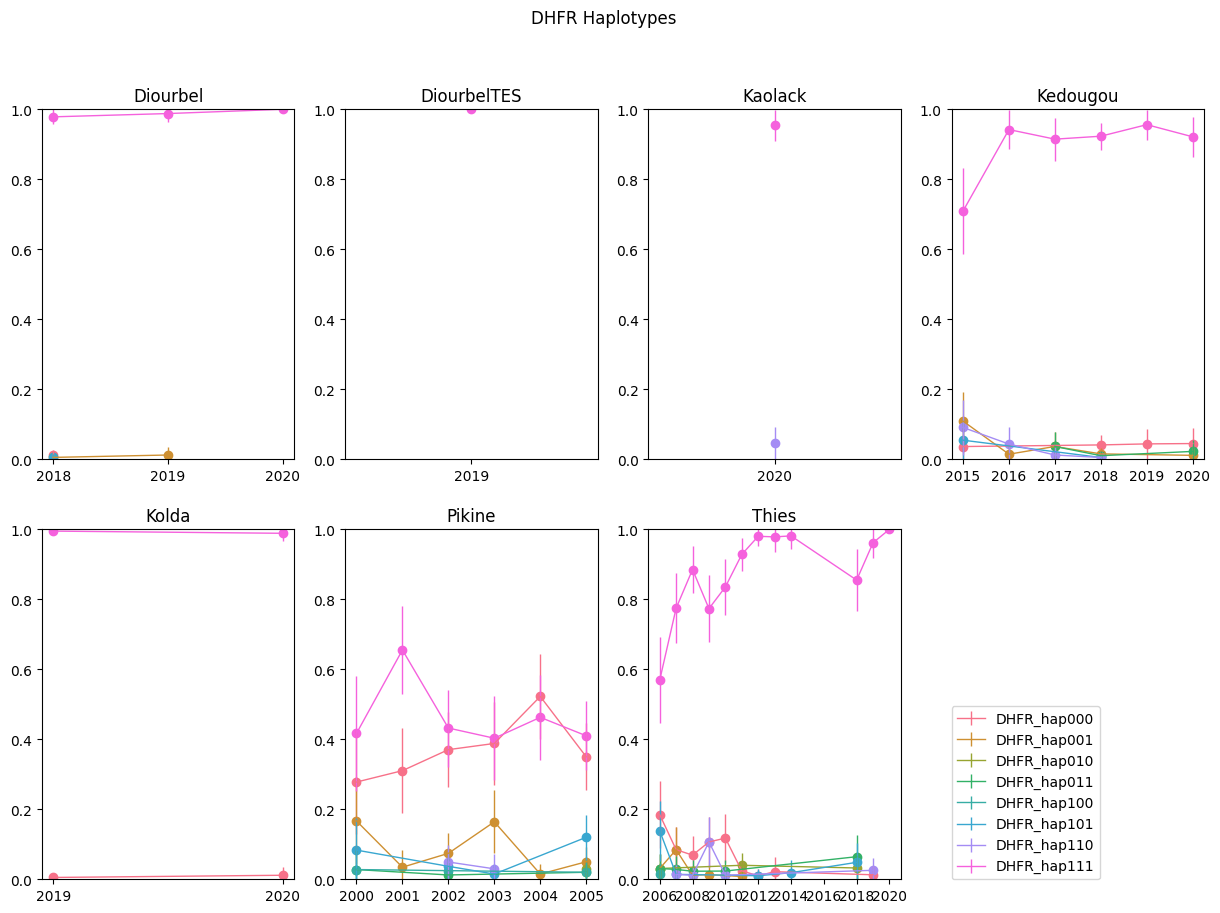

In [9]:
fig = plt.figure(figsize=(15,10))
axes = [fig.add_subplot(2,4,i+1) for i in range(len(longitudinal_drugR.keys()))]
fig.suptitle('DHFR Haplotypes')
for i,location in enumerate(longitudinal_drugR.keys()):
    colors = sns.color_palette('husl', len(dhfr1_haps))
    for c_idx, drugR in enumerate(dhfr1_haps):
        years = []
        p_mut_array = []
        stdev_array = []
        for x,year in zip(longitudinal_drugR[location][drugR],geographic_dfs[location]):
            if ~np.isnan(x[0]):
                years.append(year)
                p_mut_array.append(x[0])
                stdev_array.append(2*x[1])
        
        if years:
            if drugR == 'MDR1_hap010':
                color = 'black'
                linewidth = 2
            else:
                color = colors[c_idx]
                linewidth = 1
            axes[i].errorbar(years, 
                                p_mut_array,
                                stdev_array, label =drugR, 
                                color = color, linewidth = linewidth)
            axes[i].scatter(years,p_mut_array, color =color)
            
    years = list(geographic_dfs[location].keys())
    if location != 'Thies':
        stepsize = 1
    else:
        stepsize = 2
    axes[i].set_xticks(range(years[0], years[-1] + 1,stepsize))
    axes[i].set_xticklabels(range(years[0], years[-1] + 1,stepsize))
    axes[i].set_ylim(0,1)
    axes[i].set_title(location)
        
axes[i].legend(loc=(1.2,0))

In [10]:
def create_binom_model(location, exclude_drugR = [], verbose = False):
    glm_binom_models = {}
    for drugR in drug_mutations:
        for mutation in drug_mutations[drugR]:
            if mutation not in exclude_drugR:
                years = []
                success,totals = [],[]
                for i,x in enumerate(longitudinal_drugR[location][mutation]):
                    p,total = x[0], x[-1]
                    if ~np.isnan(p) and x[-1] != 0:
                        success.append(p * total)
                        totals.append(total)
                        years.append(list(geographic_dfs[location].keys())[i])
            if len(years) >=3:
                try:
                    success = np.asarray([round(x) for x in success])
                    X = sm.add_constant(years)
                    failures = np.asarray(totals) - success
                    y = np.asarray([[s,f] for s,f in zip(success, failures)])
                    glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
                    res = glm_binom.fit()
                    glm_binom_models[mutation] = res
                except:
                    if verbose:
                        print('fail ', mutation)

    return glm_binom_models

def plot_drugR_longitudinal(location, excluded_drugR = [], glm = True):
    title = 'Antimalarial Drug Resistance Markers in {location}'.format(location=location)
    if len(geographic_dfs[location]) > 2:
        plt.figure(figsize=(12,8))
        #plt.suptitle(title, fontsize = 20)
        errorbar_format = ''
        linewidth = 1
        for i,drugR_gene in enumerate(['PFCRT','DHFR','DHPS','MDR1','K13']):
            plt.subplot(2,3,i+1)
            colors = sns.color_palette('husl', len(drug_mutations))
            for c_idx, mutation in enumerate(drug_mutations[drugR_gene]):
                if mutation not in excluded_drugR:
                    years = np.asarray([year for year in geographic_dfs[location]])
                    p_mut_array = np.asarray([x[0] for x in longitudinal_drugR[location][mutation]])
                    stdev_array = np.asarray([2*x[1] for x in longitudinal_drugR[location][mutation]])
                    samples_size= np.asarray([x[2] for x in longitudinal_drugR[location][mutation]])
                    mask = np.asarray([True if x !=0 else False for x in p_mut_array])
                    if glm:
                        glm_binom_models = create_binom_model(location)
                        x = list(geographic_dfs[location].keys())
                        X = sm.add_constant(x)
                        if mutation in glm_binom_models:
                            predictions = glm_binom_models[mutation].get_prediction(X)
                            predictions_summary = predictions.summary_frame(alpha=0.05)
                            plt.plot(x, list(predictions_summary['mean']), color = colors[c_idx])
                            plt.fill_between(x, list(predictions_summary['mean_ci_upper']), 
                                             list(predictions_summary['mean_ci_lower']), 
                                             color = colors[c_idx], alpha = 0.3)
                            errorbar_format = ''
                            linewidth = 0.5
                    label = mutation.split(drugR_gene)[1]
                    if label == 'N51C':
                        label = 'N51I'
                    plt.errorbar(years, 
                                 p_mut_array,
                                 stdev_array, label = label, 
                                 color = colors[c_idx], fmt = errorbar_format, linewidth = linewidth)
                    
                    #plt.scatter()
                    plt.scatter(years[~mask],p_mut_array[~mask], s=100, color = colors[c_idx], marker = 'x') 
                    plt.scatter(years[mask],p_mut_array[mask], s=100, color = colors[c_idx], marker = '.') 
                    if years[-1] - years[0] > 5:
                        stepsize= 2
                    else:
                        stepsize = 1
                    plt.xticks(range(years[0], years[-1] + 1,stepsize) , 
                               range(years[0], years[-1] + 1,stepsize))

                    plt.legend()
            plt.title('ABCDEFGHI'[i], fontsize = 18, loc = 'left')
            plt.xlabel('Year', fontsize = 15)
            plt.ylabel('Frequency', fontsize = 15)
            plt.tick_params(labelsize = 12)
            plt.ylim(-0.05,1.05)
            plt.xticks(rotation =45)
            #plt.xlim(1999,2021)
            
        plt.subplot(2,3,6)

        
        """idx = 0
        ruler_strings = ['0-10', '10-50', '50-100', '100+']
        plt.annotate('Sample Size', (0,-0.3), fontsize = 15)
        for x,y in zip(y_array, range(len(sample_ruler))):
            plt.annotate(ruler_strings[idx], (x+ 0.005,y+0.1), fontsize = 15)
            idx += 1"""
        
        plt.ylim(-0.3, 3.3)
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
        plt.xlim(-0.005)
        plt.yticks(fontsize = 12)
        plt.ylabel('Sample Size', fontsize = 15)
        plt.gca().axis('off')

    else:
        print(location)


/Users/weswong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


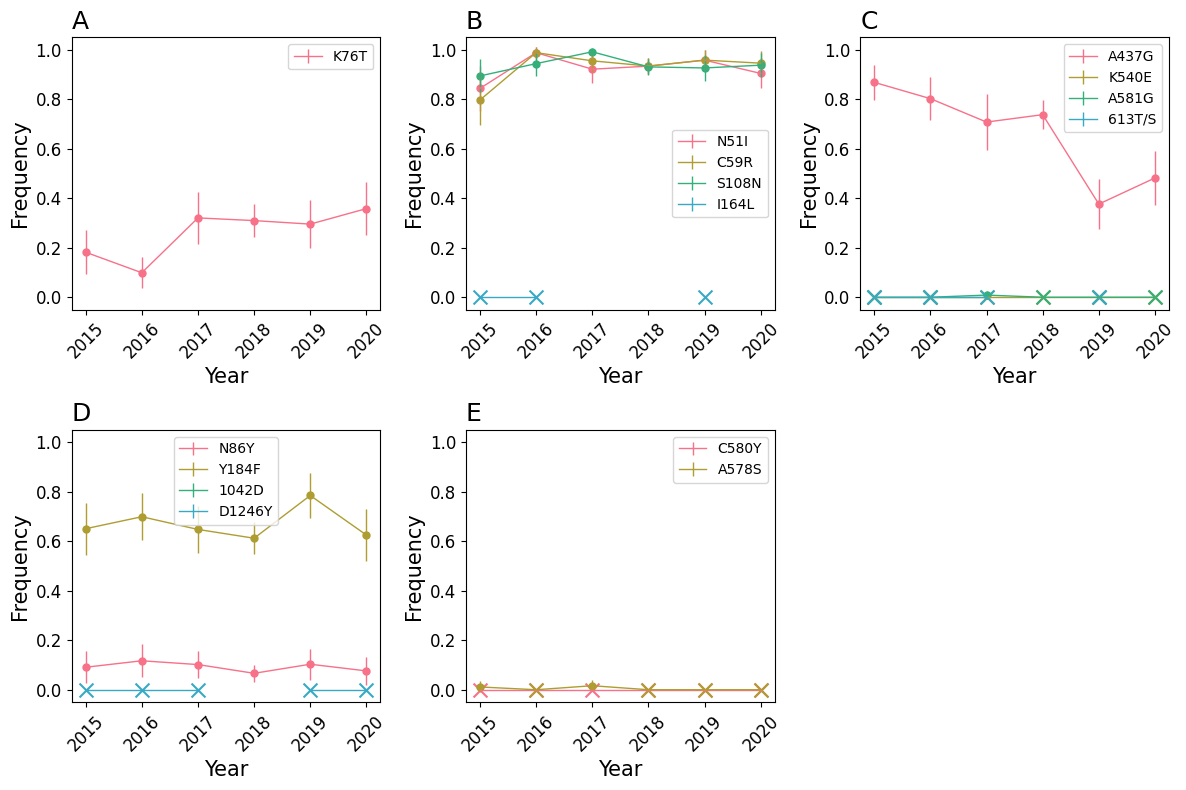

In [11]:
plot_drugR_longitudinal('Kedougou', excluded_drugR=[], glm=False)#['K13C580Y', 'DHPSK540E', 'DHPS613T/S', 'DHFRI164L', 'MDR1D1246Y'])

In [12]:
years = []
success,totals = [],[]
for i,x in enumerate(longitudinal_drugR['Kedougou']['PFCRTK76T']):
    year = list(geographic_dfs['Kedougou'].keys())[i]
    if year >=2014:
        p,total = x[0], x[-1]
        if ~np.isnan(p) and x[-1] != 0:
            success.append(p * total)
            totals.append(total)
            years.append(list(geographic_dfs['Kedougou'].keys())[i])

success = np.asarray([round(x) for x in success])
X = sm.add_constant(years)
failures = np.asarray(totals) - success
y = np.asarray([[s,f] for s,f in zip(success, failures)])
glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
res = glm_binom.fit()

In [13]:
longitudinal_drugR.keys()

dict_keys(['Diourbel', 'DiourbelTES', 'Kaolack', 'Kedougou', 'Kolda', 'Pikine', 'Thies'])

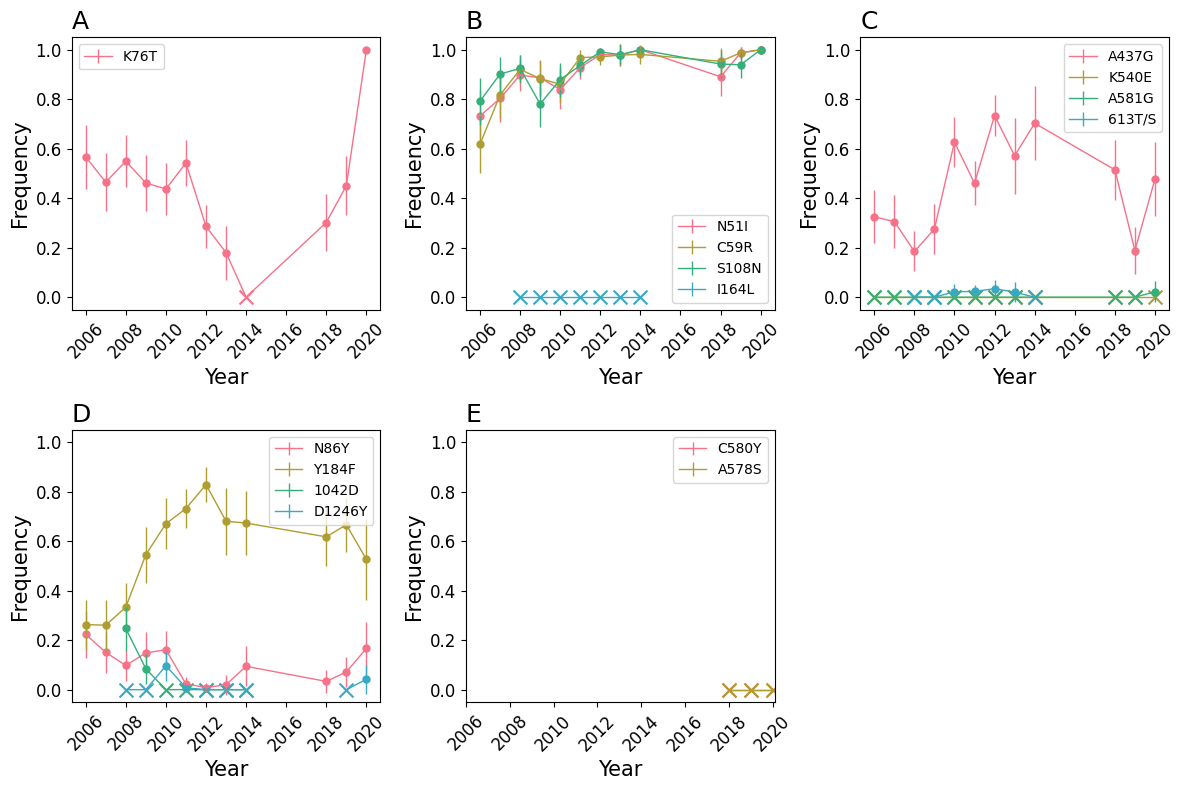

In [14]:
plot_drugR_longitudinal('Thies', excluded_drugR=[], glm=False)#['K13C580Y', 'DHPSK540E', 'DHPS613T/S', 'DHFRI164L', 'MDR1D1246Y'])

/Users/weswong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


(-1.0, -0.3)

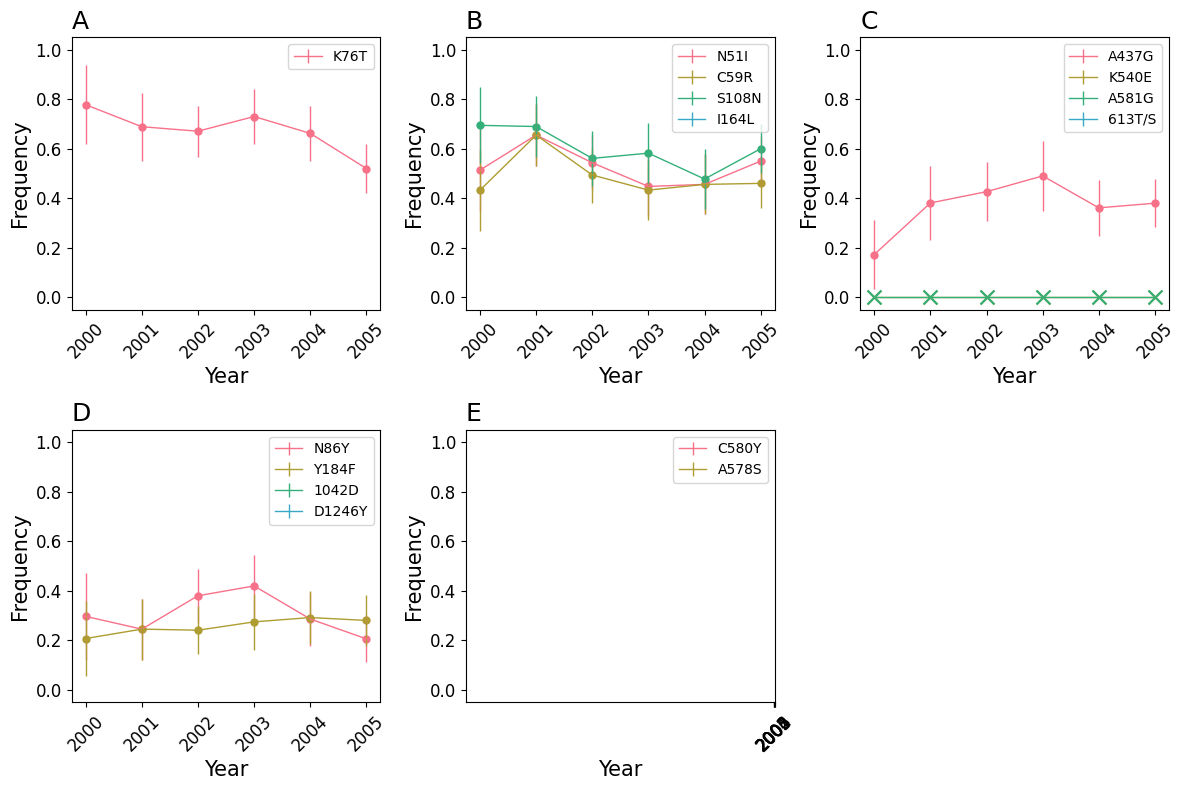

In [57]:
plot_drugR_longitudinal('Pikine', 
                        excluded_drugR=[],
                       glm=False)
plt.ylim(-1,)

In [16]:
def plot_drugR_longitudinal_drug(mutation, exclude_locations = [], glm = True):
    plt.figure(figsize=(10,5))
    locations = [location for location in geographic_dfs if (len(geographic_dfs[location]) > 2) & (location not in exclude_locations)]
    colors = sns.color_palette('husl',len(locations)).as_hex()
    for c_idx, location in enumerate(locations):
        errorbar_format = ''
        linewidth = 1


        years = np.asarray([year for year in geographic_dfs[location]])
        p_mut_array = np.asarray([x[0] for x in longitudinal_drugR[location][mutation]])
        stdev_array = np.asarray([2*x[1] for x in longitudinal_drugR[location][mutation]])
        samples_size= np.asarray([x[2] for x in longitudinal_drugR[location][mutation]])
        mask = np.asarray([True if x !=0 else False for x in p_mut_array])
        
        plt.errorbar(years, 
                                     p_mut_array,
                                     stdev_array, label = location, 
                                     color = colors[c_idx], fmt = errorbar_format, linewidth = linewidth)

        #plt.scatter()
        plt.scatter(years[~mask],p_mut_array[~mask], s=100, color = colors[c_idx], marker = 'x') 
        plt.scatter(years[mask],p_mut_array[mask], s=100, color = colors[c_idx], marker = '.') 

        plt.xlabel('Year', fontsize = 15)
        plt.ylabel('Frequency', fontsize = 15)
        plt.tick_params(labelsize = 12)
        plt.ylim(-0.05,1.05)
        plt.legend()

In [17]:
class DrugR:
    def __init__(self):
        self.years = []
        self.location = []
        self.success = []
        self.sample_size =[]
    
    def add_stats(self, years, location, success, sample_size):
        self.years += list(years)
        self.location += list(location)
        self.success += list(success)
        self.sample_size += list(sample_size)
        
    def generate_dataframe(self):
        self.df = DataFrame()
        self.df['years'] = self.years
        self.df['location'] = self.location
        self.df['success'] = self.success
        self.df['sample_size'] = self.sample_size
        self.df['failure'] = self.sample_size - self.df['success']
        self.df['p_success'] = np.asarray(self.success)/np.asarray(self.sample_size)
        self.df['binom_std'] = np.sqrt((self.df['p_success'] * (1. - self.df['p_success'])) / self.sample_size)
        shift_num = np.asarray(self.success) + 1
        shift_denom = np.asarray(self.sample_size) + 1
        self.df['p_success_shifted'] =  shift_num/shift_denom
        
        for location in self.location:
            header = 'is_{x}'.format(x=location)
            self.df[header] = self.df['location'] == location
        
        self.df.dropna(inplace=True)
        self.df = self.df.sort_values('years')

mutations = longitudinal_drugR['Thies'].keys()
consolidated_dfs = {}
for mutation in mutations:
    consolidated_dfs[mutation] = DrugR()

for location in [location for location in geographic_dfs if len(geographic_dfs[location]) > 2]:
    for mutation in mutations:
        #print(location, mutation)
        years = np.asarray([year for year in geographic_dfs[location]])
        p_mut_array = np.asarray([x[0] for x in longitudinal_drugR[location][mutation]])
        sample_size= np.asarray([x[2] for x in longitudinal_drugR[location][mutation]])
        success = p_mut_array * sample_size
        consolidated_dfs[mutation].add_stats(years, [location] * len(years), success, sample_size)

for mutation in mutations:
    consolidated_dfs[mutation].generate_dataframe()


def linearize_drugR_data(mutation, fig_ax = None, location_colors = location_cpalette, legend=True):
    consolidated_dfs[mutation].df
    y = np.asarray(consolidated_dfs[mutation].df['p_success'])
    X = np.asarray(consolidated_dfs[mutation].df[['years','is_Diourbel', 
                                                     'is_Kedougou', 'is_Pikine', 'is_Thies']])
    gam = GAM(s(0) + l(1) + l(2) + l(3) + l(4)).fit(X,y) #only years is spline, the rest of the mixed effects are linear
    gam = gam.gridsearch(X,y)

    new_X = np.zeros(np.shape(X))
    new_X.T[0] = X.T[0]

    upper = gam.confidence_intervals(new_X).T[1]
    lower = gam.confidence_intervals(new_X).T[0]
    
    if not fig_ax:
        fig, ax = plt.subplots()
    else:
        fig,ax = fig_ax
    #if not color_guide:
    #    color_guide = {'sim': 'orange', 
    #                  'cpalette':'rocket'}
    ax.plot(new_X.T[0], gam.predict(new_X), color = 'orange')
    #
    #plt.plot(X, gam.predict(X), color = 'orange')
    ax.fill_between(list(X.T[0]), 
                     upper, lower, alpha = 0.2, color = 'orange')


    #location_colors = sns.color_palette(color_guide['cpalette'], 4).as_hex()
    c_idx = 0
    for location, df in consolidated_dfs[mutation].df.groupby('location'):

        ax.scatter(df['years'], df['p_success'],
                    color = location_colors[location], label = location)
        ax.errorbar(df['years'], df['p_success'], 
                     yerr = 2 * df['binom_std'], 
                     color = location_colors[location], linewidth = 0.5, capsize = 3)
        c_idx += 1
    if legend:
        ax.legend(fontsize = 12)
    ax.tick_params(labelsize = 12)
    ax.set_ylabel('Proportion', fontsize = 15)
    ax.set_xlabel('Year', fontsize = 15)
    ax.set_title(mutation, fontsize = 15)
    
    ax.set_ylim(0,1)
    return fig, ax

In [18]:
def plot_timeline(ax):
    rect_cq = patches.Rectangle((2000, -0.05), 2003-2000, 0.02, linewidth=1, 
                            facecolor=therapeutic_cpalettes[0])
    ax.add_patch(rect_cq)
    rect_spaq = patches.Rectangle((2003, -0.05), 2006-2003, 0.02, linewidth=1, 
                                facecolor=therapeutic_cpalettes[1])
    ax.add_patch(rect_spaq)
    
    rect_asaq1 = patches.Rectangle((2006, -0.05), 2010-2006, 0.02, linewidth=1, 
                                facecolor=therapeutic_cpalettes[2])
    ax.add_patch(rect_asaq1)
    rect_asaq2 = patches.Rectangle((2010, -0.05), 2022-2010, 0.02, linewidth=1, 
                                facecolor=therapeutic_cpalettes[3])
    ax.add_patch(rect_asaq2)
    rect_coartem = patches.Rectangle((2008, -0.07), 2022-2008, 0.02, linewidth=1, 
                            facecolor=therapeutic_cpalettes[4])
    ax.add_patch(rect_coartem)
    
    rect_iptp = patches.Rectangle((2004, -0.09), 2022-2004, 0.02, linewidth=1, 
                                facecolor=prophylaxis_cpalettes[0])
    ax.add_patch(rect_iptp)
    rect_smc = patches.Rectangle((2013, -0.11), 2022-2013, 0.02, linewidth=1, 
                                facecolor=prophylaxis_cpalettes[1])
    ax.add_patch(rect_smc)
    ax.scatter([2014], [-0.13], marker = '^', color = 'red', s = 100)
    ax.scatter([2018], [-0.13], marker = '^', color = 'green', s = 100)

(1999.0, 2023.0, 0.88, 1.05)

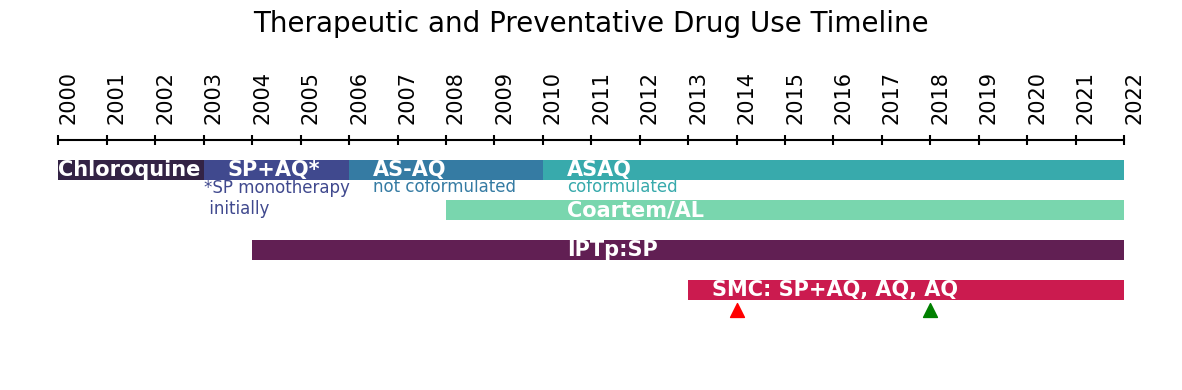

In [19]:
therapeutic_cpalettes = sns.color_palette('mako', 5).as_hex()

prophylaxis_cpalettes = sns.color_palette('rocket', 3).as_hex()
fig = plt.figure(figsize=(15,15))

spec = fig.add_gridspec(ncols=3, nrows = 3)
ax0 = fig.add_subplot(spec[0,:])

years = range(2000,2023)
y_1 = np.asarray([1 for x in range(2000,2023)])
ax0.plot(years, y_1, color = 'black')
ax0.scatter(years, y_1, marker = '|', color = 'black', s = 50)

for x,y, text in zip(years, y_1,years):
    ax0.annotate(text, xy=(x,y+0.01), rotation = 90, fontsize = 15)

ax0.set_ylim(0.88, 1.05)
ax0.set_xlim(1999,2023)
rect_cq = patches.Rectangle((2000, 0.98), 2003-2000, 0.01, linewidth=1, 
                            facecolor=therapeutic_cpalettes[0])
ax0.add_patch(rect_cq)
ax0.annotate('Chloroquine', xy = (2000, 0.982), fontsize = 15, weight = 'bold', color = 'white')

rect_spaq = patches.Rectangle((2003, 0.98), 2006-2003, 0.01, linewidth=1, 
                            facecolor=therapeutic_cpalettes[1])
ax0.add_patch(rect_spaq)
ax0.annotate('SP+AQ*', xy = (2003+ 0.5, 0.982), fontsize = 15, weight = 'bold', color = 'white')
ax0.annotate('*SP monotherapy\n initially', xy = (2002.5+ 0.5, 0.963), fontsize = 12,
             color = therapeutic_cpalettes[1])



rect_asaq1 = patches.Rectangle((2006, 0.98), 2010-2006, 0.01, linewidth=1, 
                            facecolor=therapeutic_cpalettes[2])
ax0.add_patch(rect_asaq1)
ax0.annotate('AS-AQ', xy = (2006+ 0.5, 0.982), fontsize = 15, weight = 'bold', color = 'white')
ax0.annotate('not coformulated', xy = (2006+ 0.5, 0.974), fontsize = 12, color = therapeutic_cpalettes[2])


rect_asaq2 = patches.Rectangle((2010, 0.98), 2022-2010, 0.01, linewidth=1, 
                            facecolor=therapeutic_cpalettes[3])
ax0.add_patch(rect_asaq2)
ax0.annotate('ASAQ', xy = (2010+ 0.5, 0.982), fontsize = 15, weight = 'bold', color = 'white')
ax0.annotate('coformulated', xy = (2010+ 0.5, 0.974), fontsize = 12, color = therapeutic_cpalettes[3])

rect_coartem = patches.Rectangle((2008, 0.96), 2022-2008, 0.01, linewidth=1, 
                            facecolor=therapeutic_cpalettes[4])
ax0.add_patch(rect_coartem)
ax0.annotate('Coartem/AL', xy = (2010+ 0.5, 0.962), fontsize = 15, weight = 'bold', color = 'white')

rect_iptp = patches.Rectangle((2004, 0.94), 2022-2004, 0.01, linewidth=1, 
                            facecolor=prophylaxis_cpalettes[0])
ax0.add_patch(rect_iptp)
ax0.annotate('IPTp:SP', xy = (2010+ 0.5, 0.942), fontsize = 15, weight = 'bold', color = 'white')

rect_smc = patches.Rectangle((2013, 0.92), 2022-2013, 0.01, linewidth=1, 
                            facecolor=prophylaxis_cpalettes[1])
ax0.add_patch(rect_smc)
ax0.annotate('SMC: SP+AQ, AQ, AQ', xy = (2013+ 0.5, 0.922), fontsize = 15, weight = 'bold', color = 'white')
ax0.scatter([2014], [0.915], marker = '^', color = 'red', s = 100)
ax0.scatter([2018], [0.915], marker = '^', color = 'green', s = 100)
#ax0.axis('off')
ax0.set_title('Therapeutic and Preventative Drug Use Timeline', fontsize = 20)

#rect_mda = patches.Rectangle((2021, 0.90), 2022-2021, 0.01, linewidth=1, 
#                            facecolor=prophylaxis_cpalettes[2])
#ax0.add_patch(rect_mda)
#ax0.annotate('MDA: DP + PQ', xy = (2018+ 0.5, 0.89), 
#             fontsize = 15, weight = 'bold', color = prophylaxis_cpalettes[2])
#ax0.annotate('Tambacounda Region Only', xy = (2018+ 0.5, 0.88), 
#             fontsize = 12, color = prophylaxis_cpalettes[2])
ax0.axis('off')

#fig.savefig('Timeline_final.svg')

In [20]:
#generate glm files
for mutation in consolidated_dfs:
    consolidated_dfs[mutation].df.to_csv('glm_files/glm_{mutation}.csv'.format(mutation=mutation.replace('/','_')))
    
    

In [21]:
downsampled_success = np.random.binomial([27 for _ in consolidated_dfs['PFCRTK76T'].df['p_success']], 
                       consolidated_dfs['PFCRTK76T'].df['p_success'], size = (500, 27))


downsampled_success_p = downsampled_success/27.

In [22]:
bootstrap_df = DataFrame(consolidated_dfs['PFCRTK76T'].df[['years', 'location', 'p_success',
                                                          'binom_std']])

idx = 0
for downsample in downsampled_success_p:
    bootstrap_df[idx] = downsample
    idx += 1
columns = range(500)
bootstrap_df['bootstrap_mean'] = np.mean(bootstrap_df[columns], axis = 1)
bootstrap_df['bootstrap_std'] = np.std(bootstrap_df[columns], axis = 1)

/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_16464/3227241373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bootstrap_df[idx] = downsample
/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_16464/3227241373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bootstrap_df[idx] = downsample
/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_16464/3227241373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

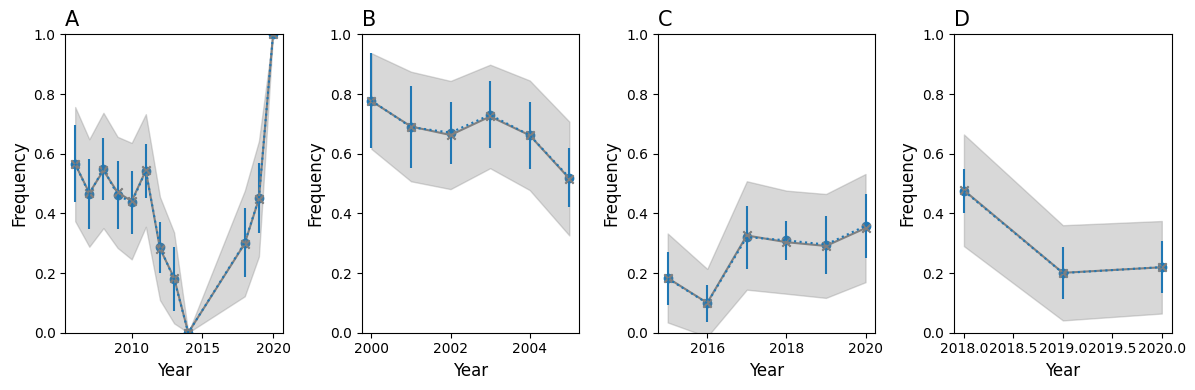

In [23]:
i = 1
plt.figure(figsize=(12,4))
for location in ['Thies', 'Pikine', 'Kedougou', 'Diourbel']:
    df = bootstrap_df[bootstrap_df['location'] == location]
    plt.subplot(1,4,i)
    plt.scatter(df['years'], df['p_success']) 
    plt.errorbar(df['years'],df['p_success'], yerr = 2* df['binom_std'], linestyle= ':')
    plt.scatter(df['years'], df['bootstrap_mean'], color = 'grey', marker='x')
    plt.plot(df['years'], df['bootstrap_mean'], color = 'grey', marker='x')
    plt.fill_between(df['years'],
    y1 = df['bootstrap_mean'] - 2*df['bootstrap_std'], 
    y2 = df['bootstrap_mean'] + 2*df['bootstrap_std'], color = 'grey', alpha = 0.3)
    plt.title("ABCD"[i-1], loc = 'left', fontsize = 15)
    i += 1
    plt.ylim(0,1)
    #print(location, df)
    plt.xlabel('Year', fontsize = 12)
    plt.ylabel('Frequency', fontsize = 12)


plt.tight_layout()
#plt.savefig('/Users/weswong/Wirth Lab Dropbox/wes wong/DrugR/Figures/Sfig5.svg')

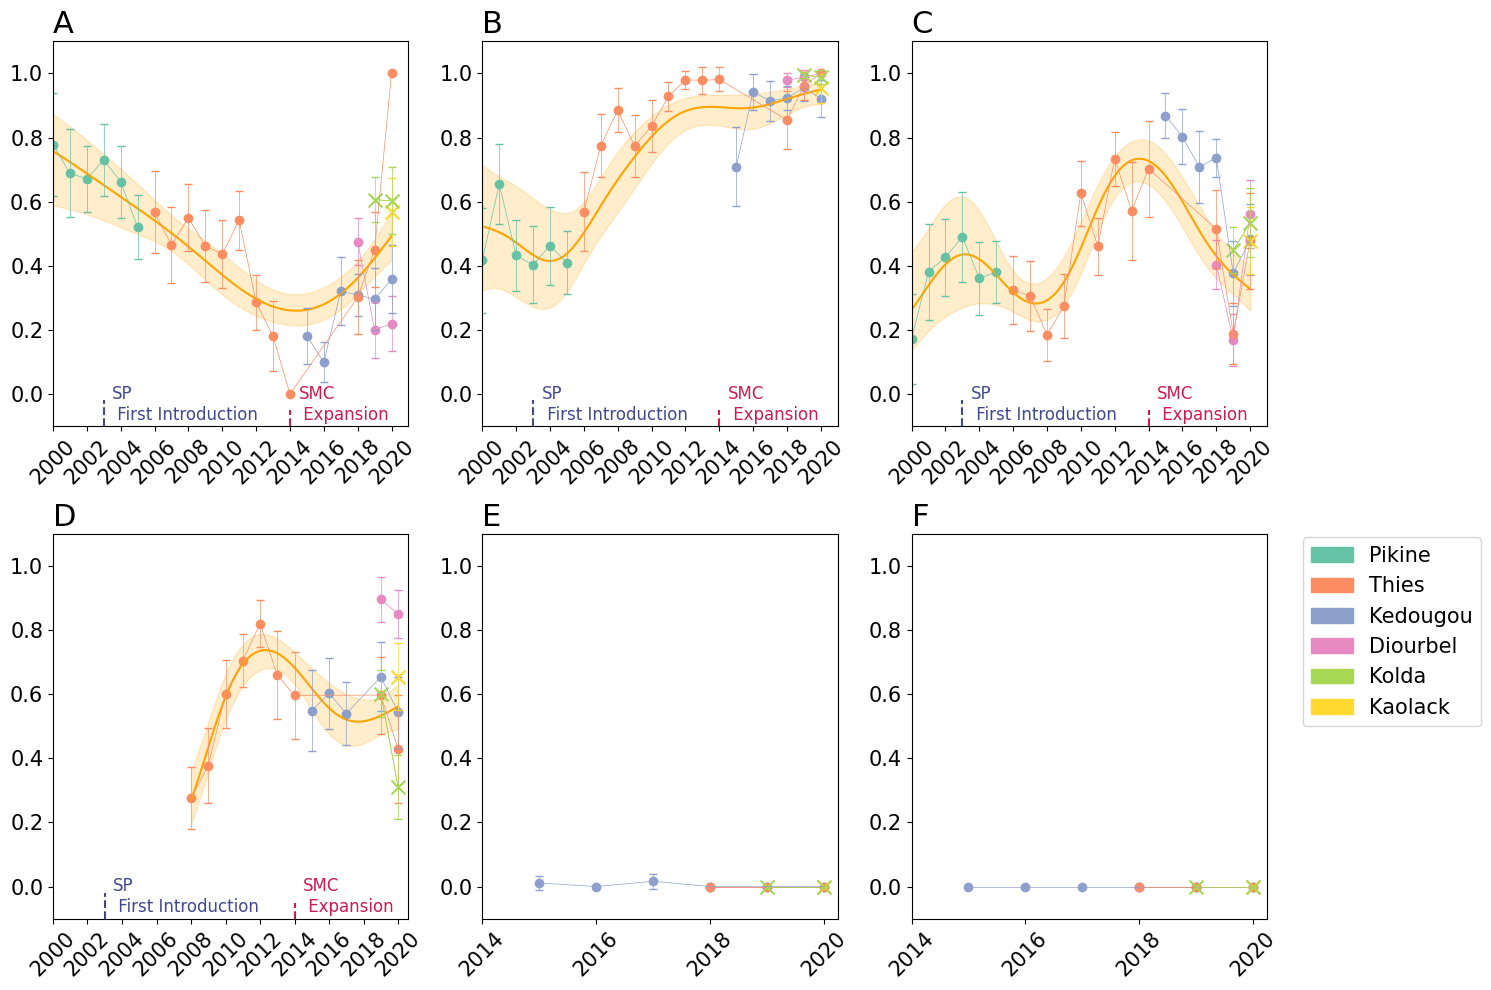

In [24]:
fig = plt.figure(figsize=(15,10))
axes = [fig.add_subplot(2,3,i+1) for i in range(6)]

gam_results_df = {}
plot_idx = 0
for mutation in ['PFCRTK76T', 'DHFR_hap111', 'DHPSA437G', 'MDR1_hap010', 'K13A578S', 'K13C580Y']:
    gam_results_df[mutation] = read_csv('glm_files/' + mutation + '_gamresults.csv')
    if mutation not in ['K13A578S', 'K13C580Y']:
        axes[plot_idx].plot(gam_results_df[mutation]['Year'], gam_results_df[mutation]['Avge'], color = 'orange')
        axes[plot_idx].fill_between(gam_results_df[mutation]['Year'], gam_results_df[mutation]['High'],
                               gam_results_df[mutation]['Low'], alpha = 0.2, color = 'orange')
    
    axes[plot_idx].set_ylim(0,1)
    
    for location, df in consolidated_dfs[mutation].df.groupby('location'):
        axes[plot_idx].scatter(df['years'], df['p_success'],
                    color = location_cpalette[location], label = location)
        axes[plot_idx].errorbar(df['years'], df['p_success'], 
                     yerr = 2 * df['binom_std'], 
                     color = location_cpalette[location], linewidth = 0.5, capsize = 3)
        
    for location in ['Kaolack', 'Kolda']:
        years = geographic_dfs[location].keys()
        results = [result for result in longitudinal_drugR[location][mutation]]
        axes[plot_idx].scatter(years, [x[0] for x in results], marker = 'x', s = 100, 
                        color = location_cpalette[location])
        axes[plot_idx].plot(years, [x[0] for x in results], marker = 'x', linewidth = 0.5,
                     color = location_cpalette[location])
        axes[plot_idx].errorbar(years, [x[0] for x in results], 
                         yerr = 2 * np.asarray([x[1] for x in results]), 
                         color = location_cpalette[location], linewidth = 0.5, capsize = 3)
        
    plot_idx += 1
    
legend_patches =[mpatches.Patch(color=location_cpalette[key], label=key) for key in location_cpalette if key != 'DiourbelTES']
axes[5].legend(handles=legend_patches, fontsize = 15, loc = (1.1,0.5))

for i,ax in enumerate(axes):
    ax.tick_params(labelsize = 15)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(2000)
    ax.set_xticks(range(2000,2022,2))
    ax.set_xticklabels(range(2000,2022,2), fontsize = 15, rotation = 45)
    ax.set_title('')
    ax.set_title(alphabet[i], fontsize = 22, loc = 'left')
    if i <=3:
        ax.annotate('SP\n First Introduction', xy = (2003+0.5, -0.08), 
                 fontsize = 12, color = therapeutic_cpalettes[1])
        ax.plot([2003,2003],[-0.1, -0.02], '--', color = therapeutic_cpalettes[1])

        ax.plot([2014,2014],[-0.1, -0.05], '--', color = prophylaxis_cpalettes[1])
        ax.annotate('SMC\n Expansion', xy = (2014+0.5, -0.08), 
                    fontsize = 12, color = prophylaxis_cpalettes[1])
    if i >3:
        ax.set_xlim(2014,)
fig.tight_layout()



In [25]:
def create_binom_haplotype_model(location,drug_mutations, exclude_drugR = [], verbose = False):
    glm_binom_models = {}
    for mutation in drug_mutations:
            if mutation not in exclude_drugR:
                years = []
                success,totals = [],[]
                for i,x in enumerate(longitudinal_drugR[location][mutation]):
                    p,total = x[0], x[-1]
                    if ~np.isnan(p) and x[-1] != 0:
                        success.append(p * total)
                        totals.append(total)
                        years.append(list(geographic_dfs[location].keys())[i])
                #print(mutation, success, totals, years)
            if len(years) >=3:
                try:
                    success = np.asarray([round(x) for x in success])
                    X = sm.add_constant(years)
                    failures = np.asarray(totals) - success
                    y = np.asarray([[s,f] for s,f in zip(success, failures)])
                    glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
                    res = glm_binom.fit()
                    glm_binom_models[mutation] = res
                except:
                    if verbose:
                        print('fail ', mutation)

    return glm_binom_models

In [27]:
piecewise_df = consolidated_dfs['PFCRTK76T'].df[consolidated_dfs['PFCRTK76T'].df['is_Diourbel'] == True]
success = piecewise_df['success'].values
failures = piecewise_df['failure'].values
years = piecewise_df['years']

X = sm.add_constant(years)
y = np.asarray([[s,f] for s,f in zip(success, failures)])
glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
res = glm_binom.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                    3
Model:                            GLM   Df Residuals:                        1
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10.127
Date:                Thu, 23 May 2024   Deviance:                       5.5506
Time:                        12:24:19   Pearson chi2:                     5.33
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9995
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1371.4582    301.834      4.544      0.000     779.875    1963.041
years         -0.6797      0.150     -4.546      0.000      -0.973      -0.387
==============================================================================
"""

In [28]:
year_range = (consolidated_dfs['DHPSA437G'].df['years'] > 2003) & (consolidated_dfs['DHPSA437G'].df['years'] <= 2008)

piecewise_df = consolidated_dfs['DHPSA437G'].df[year_range]

success = piecewise_df['success'].values
failures = piecewise_df['failure'].values
years = piecewise_df['years'].values
X = sm.add_constant(years)
y = np.asarray([[s,f] for s,f in zip(success, failures)])
glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
res = glm_binom.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                    5
Model:                            GLM   Df Residuals:                        3
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12.921
Date:                Thu, 23 May 2024   Deviance:                       2.4609
Time:                        12:24:21   Pearson chi2:                     2.44
No. Iterations:                     4   Pseudo R-squ. (CS):             0.8025
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        434.0241    154.471      2.810      0.005     131.267     736.781
x1            -0.2168      0.077     -2.815      0.005      -0.368      -0.066
==============================================================================
"""

In [29]:
piecewise_df = consolidated_dfs['PFCRTK76T'].df[consolidated_dfs['PFCRTK76T'].df['years'] > 2014]

success = piecewise_df['success'].values
failures = piecewise_df['failure'].values
years = piecewise_df['years'].values
X = sm.add_constant(years)
y = np.asarray([[s,f] for s,f in zip(success, failures)])
glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
res = glm_binom.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                   12
Model:                            GLM   Df Residuals:                       10
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -89.997
Date:                Thu, 23 May 2024   Deviance:                       128.13
Time:                        12:24:24   Pearson chi2:                     112.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.8639
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -467.9650     98.196     -4.766      0.000    -660.426    -275.505
x1             0.2315      0.049      4.759      0.000       0.136       0.327
==============================================================================
"""

/Users/weswong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/weswong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


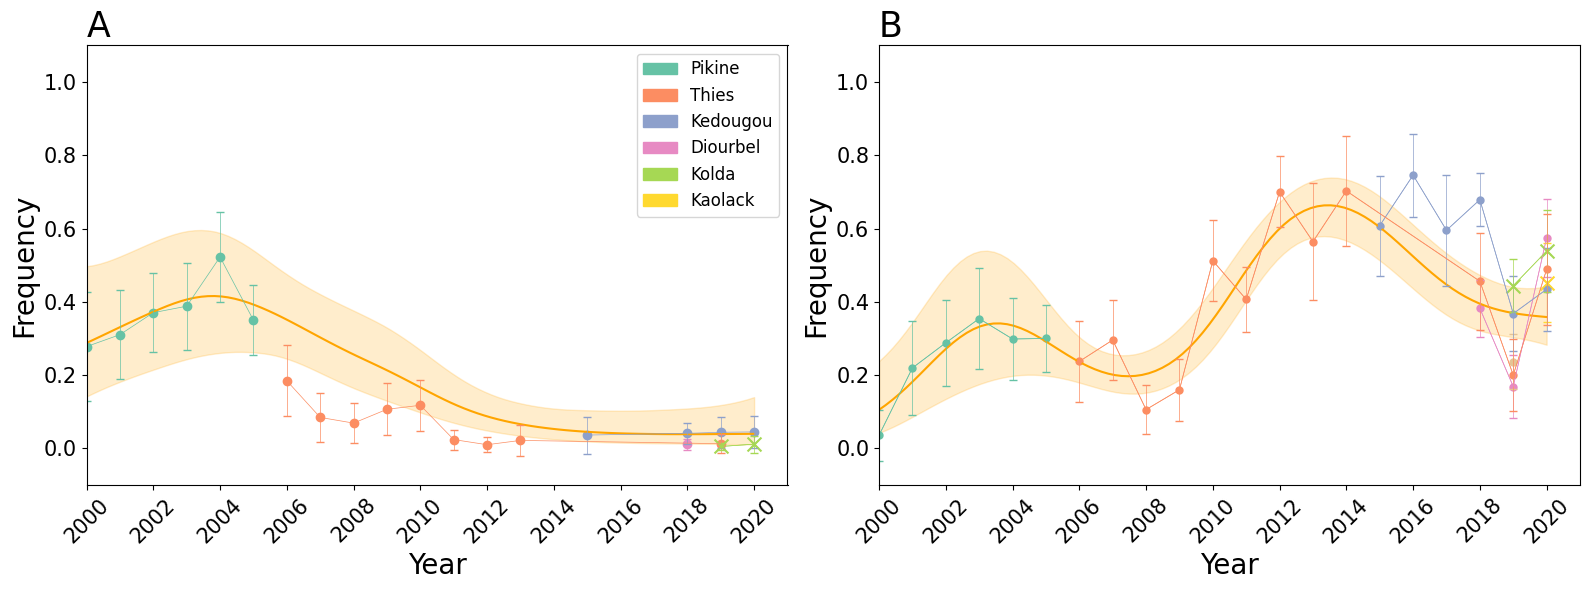

In [30]:
fig = plt.figure(figsize=(16,6))
axes = [fig.add_subplot(1,2,i+1) for i in range(2)]

gam_results_df = {}
plot_idx = 0
for mutation in ['DHFR_hap000']:
    gam_results_df[mutation] = read_csv('glm_files/' + mutation + '_gamresults.csv')
    if mutation not in ['K13A578S', 'K13C580Y']:
        axes[plot_idx].plot(gam_results_df[mutation]['Year'], gam_results_df[mutation]['Avge'], color = 'orange')
        axes[plot_idx].fill_between(gam_results_df[mutation]['Year'], gam_results_df[mutation]['High'],
                               gam_results_df[mutation]['Low'], alpha = 0.2, color = 'orange')
    
    axes[plot_idx].set_ylim(0,1)
    
    for location, df in consolidated_dfs[mutation].df.groupby('location'):
        axes[plot_idx].scatter(df['years'], df['p_success'],
                    color = location_cpalette[location], label = location)
        axes[plot_idx].errorbar(df['years'], df['p_success'], 
                     yerr = 2 * df['binom_std'], 
                     color = location_cpalette[location], linewidth = 0.5, capsize = 3)
        
    for location in ['Kaolack', 'Kolda']:
        years = geographic_dfs[location].keys()
        results = [result for result in longitudinal_drugR[location][mutation]]
        axes[plot_idx].scatter(years, [x[0] for x in results], marker = 'x', s = 100, 
                        color = location_cpalette[location])
        axes[plot_idx].plot(years, [x[0] for x in results], marker = 'x', linewidth = 0.5,
                     color = location_cpalette[location])
        axes[plot_idx].errorbar(years, [x[0] for x in results], 
                         yerr = 2 * np.asarray([x[1] for x in results]), 
                         color = location_cpalette[location], linewidth = 0.5, capsize = 3)
        axes[plot_idx].set_xticks(range(2000,2022,2))
        axes[plot_idx].set_xticklabels(range(2000,2022,2), fontsize = 15, rotation = 45)
        axes[plot_idx].tick_params(labelsize = 15)
        axes[plot_idx].set_ylim(-0.1, 1.1)
        axes[plot_idx].set_xlim(2000)
        axes[plot_idx].set_ylabel('Frequency', fontsize = 20)
        axes[plot_idx].set_xlabel('Year', fontsize = 20)

legend_patches =[mpatches.Patch(color=location_cpalette[key], label=key) for key in location_cpalette if key != 'DiourbelTES']
axes[plot_idx].legend(handles=legend_patches, fontsize = 12)
axes[0].set_title('A', fontsize = 25, loc = 'left')
#fig.savefig('/Users/weswong/Wirth Lab Dropbox/wes wong/DrugR/Figures/dhfr_000.png', dpi = 300)


quad_gam = read_csv('glm_files/Quad_gamresults.csv')
axes[1].plot(quad_gam['Year'], quad_gam['Avge'], color = 'orange')
axes[1].fill_between(quad_gam['Year'], quad_gam['High'],
                               quad_gam['Low'], alpha = 0.2, color = 'orange')
for location in longitudinal_drugR:
    if location in ['Kaolack', 'Kolda']:
        marker = 'x'
    else:
        marker = '.'
    years = geographic_dfs[location].keys()
    results = [result for result in longitudinal_drugR[location]['DHFR_DHPS_hap1111']]
    axes[1].scatter(years, [x[0] for x in results], marker = marker, s = 100, 
                        color = location_cpalette[location])
    axes[1].plot(years, [x[0] for x in results], marker = marker, linewidth = 0.5,
                     color = location_cpalette[location])
    axes[1].errorbar(years, [x[0] for x in results], 
                         yerr = 2 * np.asarray([x[1] for x in results]),
                color = location_cpalette[location], linewidth = 0.5, capsize = 3)
    
    axes[1].set_xticks(range(2000,2022,2))
    axes[1].set_xticklabels(range(2000,2022,2), fontsize = 15, rotation = 45)
    axes[1].tick_params(labelsize = 15)
    axes[1].set_ylim(-0.1, 1.1)
    axes[1].set_xlim(2000)
    axes[1].set_ylabel('Frequency', fontsize = 20)
    axes[1].set_xlabel('Year', fontsize = 20)
    axes[1].set_title('B', fontsize = 25, loc = 'left')
    
fig.tight_layout()




100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
/Users/weswong/opt/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:1247: RuntimeWarning: invalid value encountered in scalar divide
  score = score / rank
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/weswong/opt/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:1247: RuntimeWarning: invalid value encountered in scalar divide
  score = score / rank
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:  00:00:00/Users/weswong/opt/anaconda3/lib/python3.8/site-packages/pygam/pygam.py:1247: RuntimeWarning: invalid value encountered in scalar divide
  score = score / rank
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         |

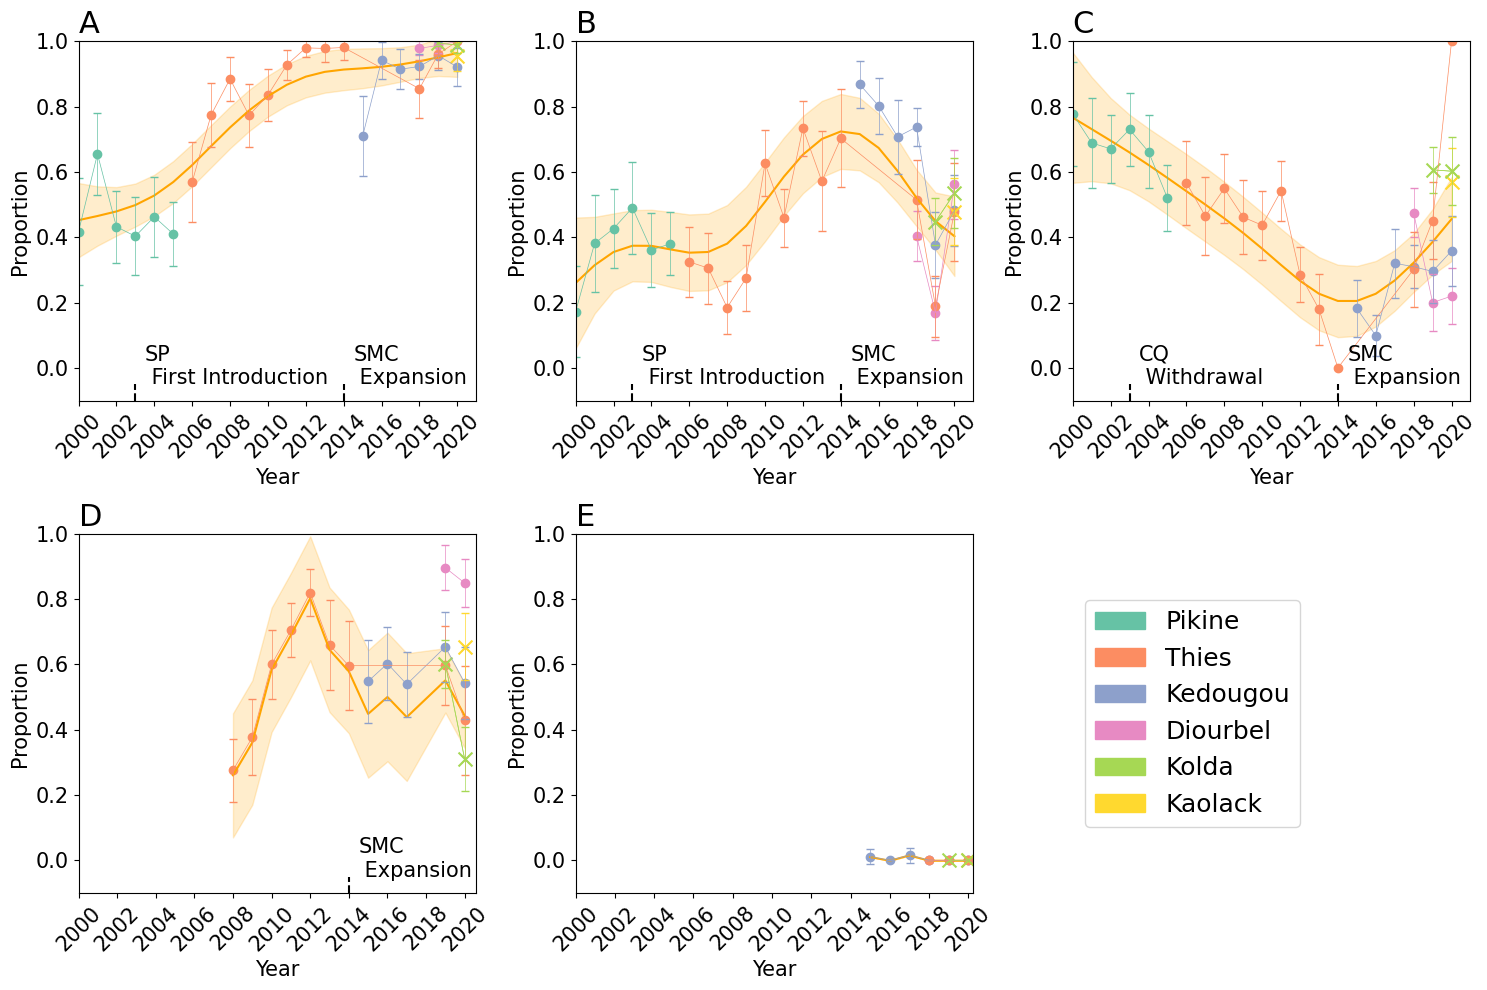

In [31]:
therapeutic_cpalettes = sns.color_palette('mako', 5).as_hex()
prophylaxis_cpalettes = sns.color_palette('rocket', 3).as_hex()

fig = plt.figure(figsize=(15,10))
axes = [fig.add_subplot(2,3,i+1) for i in range(6)]



linearize_drugR_data('DHFR_hap111', fig_ax = (fig, axes[0]), legend = False)
axes[0].plot([2003,2003],[-0.1, -0.05], '--', color = 'black')
for location in ['Kaolack', 'Kolda']:
    years = geographic_dfs[location].keys()
    results = [result for result in longitudinal_drugR[location]['DHFR_hap111']]
    axes[0].scatter(years, [x[0] for x in results], marker = 'x', s = 100, 
                    color = location_cpalette[location])
    axes[0].plot(years, [x[0] for x in results], marker = 'x', linewidth = 0.5,
                 color = location_cpalette[location])
    axes[0].errorbar(years, [x[0] for x in results], 
                     yerr = 2 * np.asarray([x[1] for x in results]), 
                     color = location_cpalette[location], linewidth = 0.5, capsize = 3)
    
axes[0].annotate('SP\n First Introduction', 
                 xy = (2003+0.5, -0.05), fontsize = 15, color = 'black')
axes[0].set_title('Pfdhfr Triple Mutant', fontsize = 20)

linearize_drugR_data('DHPSA437G', fig_ax = (fig, axes[1]), legend = False)
axes[1].set_title('Pfdhps A437G', fontsize = 20)
axes[1].plot([2003,2003],[-0.1, -0.05], '--', color = 'black')
for location in ['Kaolack', 'Kolda']:
    years = geographic_dfs[location].keys()
    results = [result for result in longitudinal_drugR[location]['DHPSA437G']]
    axes[1].scatter(years, [x[0] for x in results], marker = 'x', s = 100, 
                    color = location_cpalette[location])
    axes[1].plot(years, [x[0] for x in results], marker = 'x', linewidth = 0.5, 
                    color = location_cpalette[location])
    axes[1].errorbar(years, [x[0] for x in results], 
                     yerr = 2 * np.asarray([x[1] for x in results]), 
                     color = location_cpalette[location], linewidth = 0.5, capsize = 3)
axes[1].annotate('SP\n First Introduction', xy = (2003+0.5, -0.05), 
                 fontsize = 15, color = 'black')

linearize_drugR_data('PFCRTK76T', fig_ax = (fig, axes[2]), legend = False)
axes[2].set_title('Pfcrt K76T', fontsize = 20)
axes[2].plot([2003,2003],[-0.1, -0.05], '--', color = 'black')
axes[2].annotate('CQ\n Withdrawal', xy = (2003+0.5, -0.05), fontsize = 15, color = 'black')
for location in ['Kaolack', 'Kolda']:
    years = geographic_dfs[location].keys()
    results = [result for result in longitudinal_drugR[location]['PFCRTK76T']]
    axes[2].scatter(years, [x[0] for x in results], marker = 'x', s = 100, 
                    color = location_cpalette[location])
    axes[2].plot(years, [x[0] for x in results], marker = 'x', linewidth = 0.5, 
                    color = location_cpalette[location])
    axes[2].errorbar(years, [x[0] for x in results], 
                     yerr = 2 * np.asarray([x[1] for x in results]), 
                     color = location_cpalette[location], linewidth = 0.5, capsize = 3)
    
    
linearize_drugR_data('MDR1_hap010', fig_ax = (fig, axes[3]), legend = False)
axes[3].set_title('Pfmdr1 NFD', fontsize = 20)
for location in ['Kaolack', 'Kolda']:
    years = geographic_dfs[location].keys()
    results = [result for result in longitudinal_drugR[location]['MDR1_hap010']]
    axes[3].scatter(years, [x[0] for x in results], marker = 'x', s = 100, 
                    color = location_cpalette[location])
    axes[3].plot(years, [x[0] for x in results], marker = 'x', linewidth = 0.5, 
                    color = location_cpalette[location])
    axes[3].errorbar(years, [x[0] for x in results], 
                     yerr = 2 * np.asarray([x[1] for x in results]), 
                     color = location_cpalette[location], linewidth = 0.5, capsize = 3)
                                     
linearize_drugR_data('K13A578S', fig_ax = (fig, axes[4]), legend = False)
axes[4].set_title('Pfkelch A578S', fontsize = 20)
for location in ['Kaolack', 'Kolda']:
    years = geographic_dfs[location].keys()
    results = [result for result in longitudinal_drugR[location]['K13A578S']]
    axes[4].scatter(years, [x[0] for x in results], marker = 'x', s = 100, 
                    color = location_cpalette[location])
    axes[4].plot(years, [x[0] for x in results], marker = 'x', linewidth = 0.5, 
                    color = location_cpalette[location])
    axes[4].errorbar(years, [x[0] for x in results], 
                     yerr = 2 * np.asarray([x[1] for x in results]), 
                     color = location_cpalette[location], linewidth = 0.5)

for i,ax in enumerate(axes):
    ax.tick_params(labelsize = 15)
    ax.set_ylim(-0.1, 1)
    ax.set_xlim(2000)
    ax.set_xticks(range(2000,2022,2))
    ax.set_xticklabels(range(2000,2022,2), fontsize = 15, rotation = 45)
    ax.set_title('')
    if i not in [5]:
        ax.set_title(alphabet[i], fontsize = 22, loc = 'left')
    if i not in [4,5]:
        ax.plot([2014,2014],[-0.1, -0.05], '--', color = 'black')
        ax.annotate('SMC\n Expansion', xy = (2014+0.5, -0.05), fontsize = 15, color = 'black')


legend_patches =[mpatches.Patch(color=location_cpalette[key], label=key) for key in location_cpalette if key != 'DiourbelTES']
axes[5].legend(handles=legend_patches, fontsize = 18, loc = 'center left')
axes[5].axis('off')

fig.tight_layout()
fig.savefig('drugr_summary_v2.png', dpi = 300)
fig.savefig('drugr_summary_v2.svg', dpi = 300)

In [ ]:
for mutation in consolidated_dfs:
    consolidated_dfs[mutation].df.to_csv('glm_{mutation}.csv'.format(mutation=mutation.replace('/','_')))